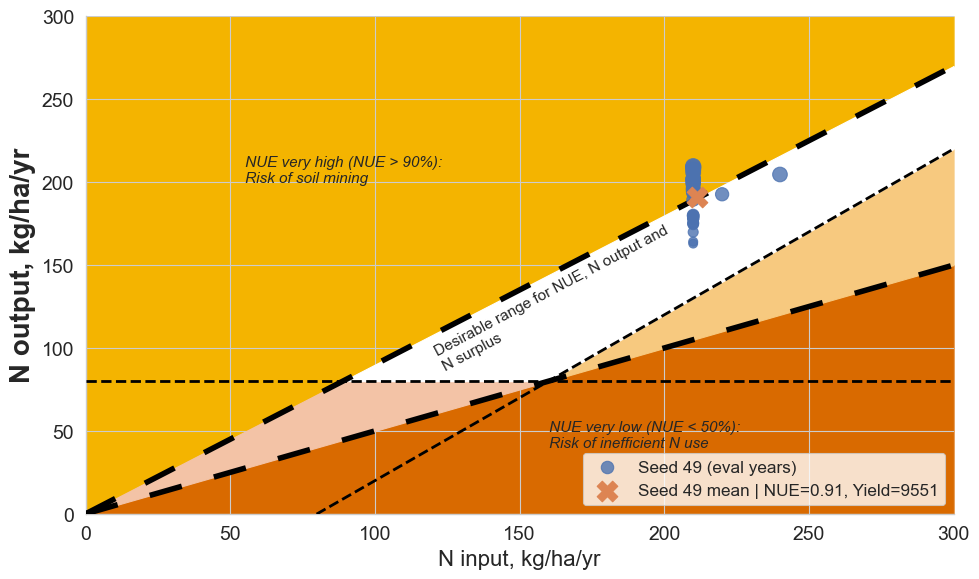

In [46]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# ============================================================
# 0) EUNEP-style background figure (redraw)
# ============================================================

project_root = Path.cwd()
relative_path = Path("results/eval_logs_nue/seed_49__eval_results_seed_49.csv")
CSV_PATH = Path("results/eval_logs_nue/seed_49__eval_results_seed_49.csv")


def plot_eunep_nue_indicator(
    xmax=300, ymax=300,
    nue_low=0.50, nue_high=0.90,
    n_output_min=80,
    n_surplus_max=80,
    figsize=(10, 6)
):
    x = np.linspace(0, xmax, 1000)
    y_low  = nue_low  * x
    y_high = nue_high * x
    y_surplus = x - n_surplus_max

    fig, ax = plt.subplots(figsize=figsize)

    col_high   = "#f4b400"
    col_low    = "#d96a00"
    col_mid    = "#f7c97f"
    col_peach  = "#f3c3a6"
    col_white  = "#ffffff"

    ax.fill_between(x, 0, np.clip(y_low, 0, ymax), color=col_low, zorder=0)
    ax.fill_between(x, np.clip(y_high, 0, ymax), ymax, color=col_high, zorder=0)

    upper_peach = np.minimum(y_high, n_output_min)
    ax.fill_between(
        x,
        np.clip(y_low, 0, ymax),
        np.clip(upper_peach, 0, ymax),
        where=(upper_peach > y_low),
        color=col_peach,
        zorder=1
    )

    upper_mid = np.minimum(y_surplus, y_high)
    ax.fill_between(
        x,
        np.clip(y_low, 0, ymax),
        np.clip(upper_mid, 0, ymax),
        where=(upper_mid > y_low),
        color=col_mid,
        zorder=2
    )

    lower_good = np.maximum(n_output_min, y_surplus)
    ax.fill_between(
        x,
        np.clip(lower_good, 0, ymax),
        np.clip(y_high, 0, ymax),
        where=(y_high > lower_good),
        color=col_white,
        zorder=3
    )

    ax.plot(x, y_high, color="black", lw=4, ls=(0, (6, 6)), zorder=4)
    ax.plot(x, y_low,  color="black", lw=4, ls=(0, (6, 6)), zorder=4)
    ax.plot(x, y_surplus, color="black", lw=2, ls="--", zorder=4)
    ax.axhline(n_output_min, color="black", lw=2, ls="--", zorder=4)

    ax.text(55, 200, "NUE very high (NUE > 90%):\nRisk of soil mining",
        fontsize=11, fontstyle="italic")
    ax.text(160, 40, "NUE very low (NUE < 50%):\nRisk of inefficient N use",
        fontsize=11, fontstyle="italic")
    ax.text(120, 85, "Desirable range for NUE, N output and\nN surplus",
        fontsize=11, rotation=28, ha="left", va="bottom")


    ax.set_xlim(0, xmax)
    ax.set_ylim(0, ymax)
    ax.set_xticks(np.arange(0, xmax + 1, 50))
    ax.set_yticks(np.arange(0, ymax + 1, 50))
    ax.set_xlabel("N input, kg/ha/yr", fontsize=16)
    ax.set_ylabel("N output, kg/ha/yr", fontsize=20, fontweight="bold")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(labelsize=14)

    return fig, ax


# ============================================================
# 1) Load seed CSV and overlay (Seed 49)
# ============================================================

df = pd.read_csv(CSV_PATH)

def resolve_col(df: pd.DataFrame, candidates, contains=None, friendly="column"):
    for c in candidates:
        if c in df.columns:
            return c
    lower_map = {c.lower(): c for c in df.columns}
    for c in candidates:
        if c.lower() in lower_map:
            return lower_map[c.lower()]
    if contains:
        for c in df.columns:
            cl = c.lower()
            if all(tok.lower() in cl for tok in contains):
                return c
    raise KeyError(
        f"Could not find {friendly}. Tried candidates={candidates}, contains={contains}. "
        f"Available columns:\n{list(df.columns)}"
    )

col_nue = resolve_col(df, ["NUE_EUNEP", "nue_eunep", "NUE", "nue"], contains=["nue"], friendly="NUE_EUNEP")
col_yld = resolve_col(df, ["Yield", "yield", "Yield_kg_ha", "yield_kg_ha", "Yield_t_ha", "yield_t_ha"],
                      contains=["yield"], friendly="Yield")
col_nin = resolve_col(df, ["Napplied", "napplied", "N_applied", "n_applied", "cum_N_applied_kg_ha", "cum_n_applied_kg_ha"],
                      contains=["appl"], friendly="Napplied (N input)")

tmp = df[[col_nin, col_nue, col_yld]].copy()
tmp = tmp.apply(pd.to_numeric, errors="coerce").dropna()

x_in = tmp[col_nin].to_numpy()
nue  = tmp[col_nue].to_numpy()
y_out = x_in * nue
yld  = tmp[col_yld].to_numpy()

sizes = 40 + 80 * (yld - np.nanmin(yld)) / (np.nanmax(yld) - np.nanmin(yld) + 1e-9)

fig, ax = plot_eunep_nue_indicator(xmax=300, ymax=300)

ax.scatter(x_in, y_out, s=sizes, alpha=0.8, zorder=10, label="Seed 49 (eval years)")

mean_xy = (float(np.mean(x_in)), float(np.mean(y_out)))
mean_nue = float(np.mean(nue))
mean_yld = float(np.mean(yld))

label_mean = f"Seed 49 mean | NUE={mean_nue:.2f}, Yield={mean_yld:.0f}"
ax.scatter([mean_xy[0]], [mean_xy[1]], s=220, marker="X", zorder=11, label=label_mean)



ax.legend(loc="lower right", frameon=True)
plt.tight_layout()
plt.show()

fig.savefig("seed49_overlay_eunep_indicator.pdf", bbox_inches="tight")


In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
project_root = Path.cwd()
# Paths to your three eval zip files
PATH_NUE        = Path("results/eval_logs_nue.zip")
PATH_YIELD      = Path("results/eval_logs_yield.zip")
PATH_FINANCIAL  = Path("results/eval_logs_financial.zip")

# Cell 2: Load all 101 seeds
ZIP_PATH = Path("results/eval_logs_yield.zip")
import zipfile
import re
import pandas as pd

def load_all_seeds(zip_path):
    """Load all seed CSVs from a zip file, infer seed from filename."""
    all_data = []

    with zipfile.ZipFile(zip_path, 'r') as z:
        # Get all CSV files
        csv_files = [f for f in z.namelist() if f.lower().endswith('.csv')]
        print(f"Found {len(csv_files)} CSV files in zip")
        print("Example names:", csv_files[:5])

        for csv_file in csv_files:
            filename = csv_file.split('/')[-1]  # strip any folder paths

            # Extract the LAST number found in the filename as seed
            match = re.findall(r'\d+', filename)
            if not match:
                print(f"Warning: Could not find any number in {filename}, skipping.")
                continue

            seed_num = int(match[-1])  # last number
            print(f"Parsing {filename} -> seed {seed_num}")

            # Read CSV
            with z.open(csv_file) as f:
                df = pd.read_csv(f)
                df["seed"] = seed_num
                all_data.append(df)

        print(f"Loaded {len(all_data)} CSVs successfully")

    if not all_data:
        raise ValueError("No CSVs were loaded. Check file names and parsing logic.")

    combined = pd.concat(all_data, ignore_index=True)
    return combined

# Load data
data = load_all_seeds(ZIP_PATH)

print(f"\n{'='*70}")
print(f"DATASET SUMMARY")
print(f"{'='*70}")
print(f"Total episodes: {len(data):,}")
print(f"Number of seeds: {data['seed'].nunique()}")
print(f"Episodes per seed: {len(data) // data['seed'].nunique()}")
print(f"Year range: {data['year'].min()} - {data['year'].max()}")
print(f"{'='*70}")

agents = {
    "NUE-focused":      load_all_seeds(PATH_NUE),
    "Yield-focused":    load_all_seeds(PATH_YIELD),
    "Financial-focused": load_all_seeds(PATH_FINANCIAL),
}


Found 101 CSV files in zip
Example names: ['eval_logs_yield/seed_0__eval_results_seed_0.csv', 'eval_logs_yield/seed_100__eval_results_seed_100.csv', 'eval_logs_yield/seed_10__eval_results_seed_10.csv', 'eval_logs_yield/seed_11__eval_results_seed_11.csv', 'eval_logs_yield/seed_12__eval_results_seed_12.csv']
Parsing seed_0__eval_results_seed_0.csv -> seed 0
Parsing seed_100__eval_results_seed_100.csv -> seed 100
Parsing seed_10__eval_results_seed_10.csv -> seed 10
Parsing seed_11__eval_results_seed_11.csv -> seed 11
Parsing seed_12__eval_results_seed_12.csv -> seed 12
Parsing seed_13__eval_results_seed_13.csv -> seed 13
Parsing seed_14__eval_results_seed_14.csv -> seed 14
Parsing seed_15__eval_results_seed_15.csv -> seed 15
Parsing seed_16__eval_results_seed_16.csv -> seed 16
Parsing seed_17__eval_results_seed_17.csv -> seed 17
Parsing seed_18__eval_results_seed_18.csv -> seed 18
Parsing seed_19__eval_results_seed_19.csv -> seed 19
Parsing seed_1__eval_results_seed_1.csv -> seed 1
Parsin

Yield | NUE-focused: n=3232, mean=9420.067, std=674.864
Yield | Yield-focused: n=3232, mean=9230.118, std=773.883
Yield | Financial-focused: n=3232, mean=9302.661, std=719.146


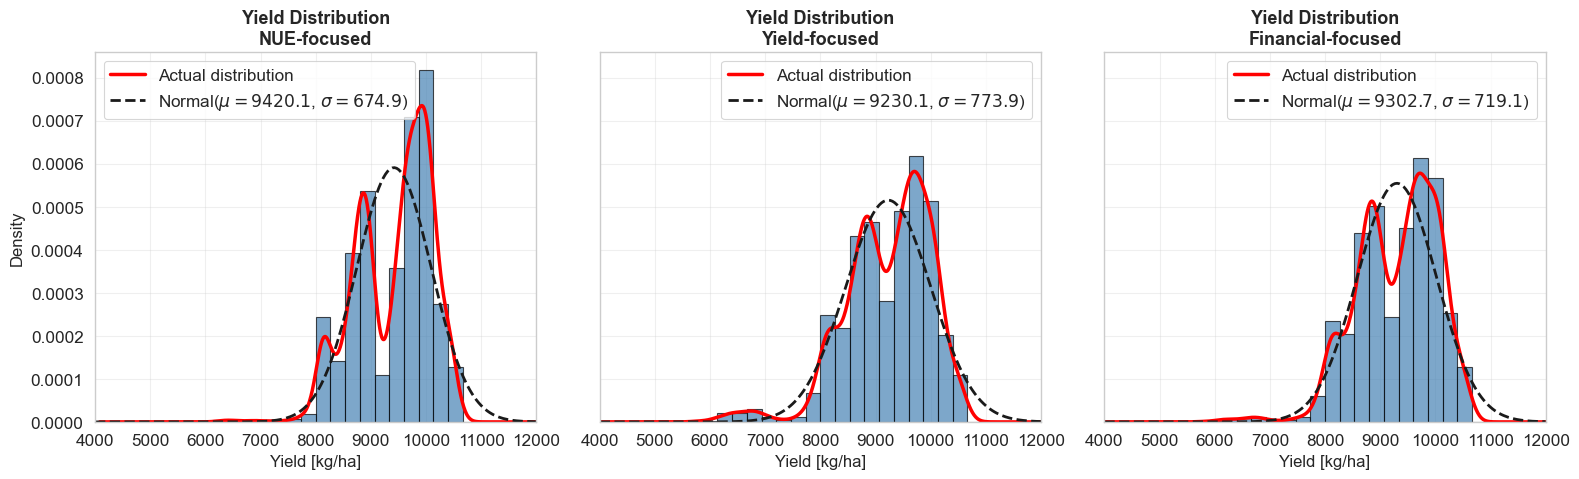

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Optional: helps match the grey background/grid look you already have
# plt.style.use("seaborn-v0_8")  # or "seaborn-v0_8-darkgrid"

# ---- Edit these per cell ----
metric  = "Yield"
xlabel  = "Yield [kg/ha]"          # your custom label
bins    = 30
xlim    = (4000, 12000)                  # e.g. (4000, 12000) or None for auto
save_as = f"h_{metric.lower()}_hist_comparison.pdf"
# -----------------------------

# Build per-agent series
series = {name: df[metric].dropna() for name, df in agents.items()}

# Use ONE common x-range + ONE common binning across agents (fair comparison)
if xlim is None:
    xmin = min(s.min() for s in series.values())
    xmax = max(s.max() for s in series.values())
    xlim = (xmin, xmax)

bin_edges = np.linspace(xlim[0], xlim[1], bins + 1)
x = np.linspace(xlim[0], xlim[1], 200)

fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)
axes = np.atleast_1d(axes)

for ax, (name, values) in zip(axes, series.items()):
    # Histogram (same as your style)
    ax.hist(values, bins=bin_edges, density=True, alpha=0.7,
            color="steelblue", edgecolor="black")

    # KDE (same as your style)
    if values.nunique() > 1:
        values.plot.kde(ax=ax, linewidth=2.5, color="red", label="Actual distribution")

    # Normal overlay (same as your style)
    mu, sigma = values.mean(), values.std(ddof=1)
    if sigma > 0:
        ax.plot(x, stats.norm.pdf(x, mu, sigma), "k--", linewidth=2,
                label=f"Normal($\\mu={mu:.1f}$, $\\sigma={sigma:.1f}$)")

    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_title(f"{metric} Distribution\n{name}", fontsize=13, fontweight="bold")
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim(*xlim)

    # Console stats (so you see numbers when you run the cell)
    print(f"{metric} | {name}: n={len(values)}, mean={mu:.3f}, std={sigma:.3f}")

axes[0].set_ylabel("Density", fontsize=12)

plt.tight_layout()
fig.savefig(save_as, bbox_inches="tight")
plt.show()


Nsurp | NUE-focused: n=3232, mean=1.2879, std=30.7790
Nsurp | Yield-focused: n=3232, mean=-13.2264, std=46.6109
Nsurp | Financial-focused: n=3232, mean=-6.8566, std=45.7627


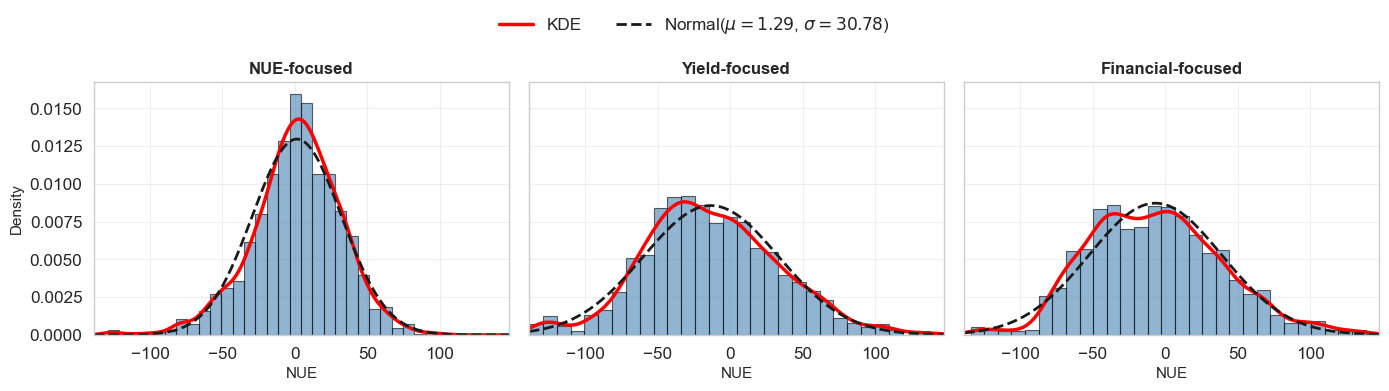

In [49]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

# --- Edit these per cell ---
metric  = "Nsurp"
xlabel  = r"NUE"     # your custom x-label
bins    = 30
xlim    = None                   # e.g. (0, 6) to zoom; None = auto from all agents
ylim    = None                    # e.g. (0, 1.2) if you want to cap density
save_as = f"h_{metric.lower()}_hist_comparison.pdf"
# ---------------------------

# Pull the series for each agent
series = {name: df[metric].dropna() for name, df in agents.items()}

# Use a common x-range across all three agents (fair comparison)
if xlim is None:
    lo = min(s.min() for s in series.values())
    hi = max(s.max() for s in series.values())
    xlim = (lo, hi)

x = np.linspace(xlim[0], xlim[1], 200)

fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharex=True, sharey=True)

for ax, (name, values) in zip(axes, series.items()):
    # Histogram
    ax.hist(values, bins=bins, density=True, alpha=0.6,
            color="steelblue", edgecolor="black")

    # KDE
    values.plot.kde(ax=ax, linewidth=2.5, color="red", label="KDE")

    # Normal overlay
    mu = values.mean()
    sigma = values.std(ddof=1)
    if sigma > 0:
        ax.plot(x, stats.norm.pdf(x, mu, sigma), "k--", linewidth=2,
                label=rf"Normal($\mu={mu:.2f}$, $\sigma={sigma:.2f}$)")

    ax.set_title(name, fontsize=12, fontweight="bold")
    ax.set_xlabel(xlabel, fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(*xlim)
    if ylim is not None:
        ax.set_ylim(*ylim)

    # Print stats to console
    print(f"{metric} | {name}: n={len(values)}, mean={mu:.4f}, std={sigma:.4f}")

axes[0].set_ylabel("Density", fontsize=11)

# One legend for the whole figure (cleaner)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3, frameon=False)

#fig.suptitle(f"{metric} distribution across agents", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.90])

fig.savefig(save_as, bbox_inches="tight")
plt.show()


Napplied | NUE-focused: n=3232, mean=189.4740, std=32.5607
Napplied | Yield-focused: n=3232, mean=171.0489, std=53.6785
Napplied | Financial-focused: n=3232, mean=178.9202, std=50.9457


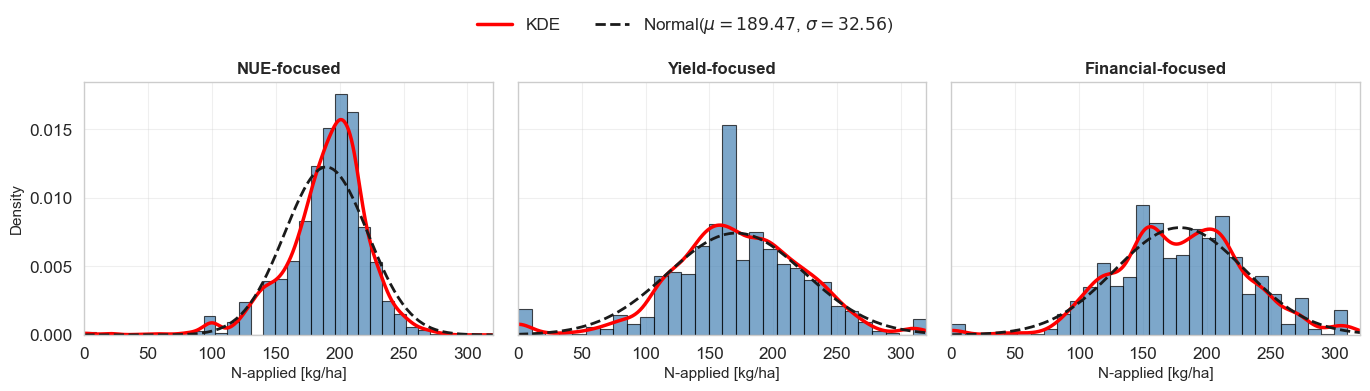

In [50]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

# --- Edit these per cell ---
metric  = "Napplied"
xlabel  = r"N-applied [kg/ha]"     # your custom x-label
bins    = 30
xlim    = None                   # e.g. (0, 6) to zoom; None = auto from all agents
ylim    = None                    # e.g. (0, 1.2) if you want to cap density
save_as = f"h_{metric.lower()}_hist_comparison.pdf"
# ---------------------------

# Pull the series for each agent
series = {name: df[metric].dropna() for name, df in agents.items()}

# Use a common x-range across all three agents (fair comparison)
if xlim is None:
    lo = min(s.min() for s in series.values())
    hi = max(s.max() for s in series.values())
    xlim = (lo, hi)

x = np.linspace(xlim[0], xlim[1], 200)

fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharex=True, sharey=True)

for ax, (name, values) in zip(axes, series.items()):
    # Histogram
    ax.hist(values, bins=bins, density=True, alpha=0.7,
            color="steelblue", edgecolor="black")

    # KDE
    values.plot.kde(ax=ax, linewidth=2.5, color="red", label="KDE")

    # Normal overlay
    mu = values.mean()
    sigma = values.std(ddof=1)
    if sigma > 0:
        ax.plot(x, stats.norm.pdf(x, mu, sigma), "k--", linewidth=2,
                label=rf"Normal($\mu={mu:.2f}$, $\sigma={sigma:.2f}$)")

    ax.set_title(name, fontsize=12, fontweight="bold")
    ax.set_xlabel(xlabel, fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(*xlim)
    if ylim is not None:
        ax.set_ylim(*ylim)

    # Print stats to console
    print(f"{metric} | {name}: n={len(values)}, mean={mu:.4f}, std={sigma:.4f}")

axes[0].set_ylabel("Density", fontsize=11)

# One legend for the whole figure (cleaner)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3, frameon=False)


fig.tight_layout(rect=[0, 0, 1, 0.90])

fig.savefig(save_as, bbox_inches="tight")
plt.show()


In [66]:
# --- Config ---

from pathlib import Path

# 1. Get the generic root folder (e.g., C:\Users\Simon\PycharmProjects\Masterthesis_Upload)
project_root = Path.cwd()

# 2. Define the relative part (NO C:\Users\...)
relative_part = Path("results/eval_logs_nue/eval_logs_nue.zip")


NSURP_RANGE = (0.0, 40.0)  # inclusive
NUE_RANGE   = (0.5, 1.0)   # inclusive, normalized 0–1
NUE_COL     = "NUE_EUNEP"
NSURP_COL   = "Nsurp"
YIELD_CANDS = ["Yield", "yield", "YIELD"]
EPISODE_CANDS = ["episode_idx", "episode", "ep", "index"]

# --- Load & prepare ---
import re, json, zipfile
import numpy as np
import pandas as pd

def _read_member(zf, name):
    with zf.open(name) as f:
        try:
            return pd.read_csv(f)
        except Exception:
            pass
    with zf.open(name) as f:
        txt = f.read().decode("utf-8", errors="ignore").strip()
    if not txt:
        return None
    # JSONL
    rows = []
    for line in txt.splitlines():
        line = line.strip()
        if not line:
            continue
        try:
            rows.append(json.loads(line))
        except Exception:
            pass
    if rows:
        return pd.DataFrame(rows)
    # Whole JSON
    try:
        obj = json.loads(txt)
        if isinstance(obj, list):
            return pd.DataFrame(obj)
        if isinstance(obj, dict):
            for k in ["results","episodes","data","items","records","evaluations"]:
                if k in obj and isinstance(obj[k], list):
                    return pd.DataFrame(obj[k])
            return pd.json_normalize(obj)
    except Exception:
        return None
    return None

frames = []
with zipfile.ZipFile(ZIP_PATH) as zf:
    for name in zf.namelist():
        if name.endswith("/"):
            continue
        df = _read_member(zf, name)
        if df is None or df.empty:
            continue
        df["_source_file"] = name
        frames.append(df)

if not frames:
    raise RuntimeError(f"No tabular data could be read from {ZIP_PATH}")

df = pd.concat(frames, ignore_index=True, sort=False)

# Identify columns
def _find_col(cols, exact=None, candidates=None, contains=None):
    low = {c.lower(): c for c in cols}
    if exact and exact.lower() in low:
        return low[exact.lower()]
    if candidates:
        for c in candidates:
            if c.lower() in low:
                return low[c.lower()]
    if contains:
        for c in cols:
            if contains.lower() in c.lower():
                return c
    return None

nue_col   = _find_col(df.columns, exact=NUE_COL) or _find_col(df.columns, contains="nue")
nsurp_col = _find_col(df.columns, exact=NSURP_COL) or _find_col(df.columns, contains="surp")
yield_col = _find_col(df.columns, candidates=YIELD_CANDS)

if nue_col is None or nsurp_col is None or yield_col is None:
    raise KeyError(f"Missing required columns; found NUE={nue_col}, Nsurp={nsurp_col}, Yield={yield_col}")

# Normalize NUE_EUNEP to 0–1 if needed (handles 0–100 inputs)
df[nue_col] = pd.to_numeric(df[nue_col], errors="coerce")
df["NUE_norm"] = np.where(df[nue_col] > 1.5, df[nue_col] / 100.0, df[nue_col])

df[nsurp_col] = pd.to_numeric(df[nsurp_col], errors="coerce")
df[yield_col] = pd.to_numeric(df[yield_col], errors="coerce")

# Seed & episode
df["seed"] = df["_source_file"].str.extract(r"seed[_\-]?(\d+)", expand=False).astype("Int64")
ep_col = _find_col(df.columns, candidates=EPISODE_CANDS)
if ep_col is None:
    df["episode_in_file"] = df.groupby("_source_file").cumcount()
    ep_col = "episode_in_file"

# Hit band (inclusive)
ns_lo, ns_hi = NSURP_RANGE
nue_lo, nue_hi = NUE_RANGE
df["hit"] = df[nsurp_col].between(ns_lo, ns_hi, inclusive="both") & df["NUE_norm"].between(nue_lo, nue_hi, inclusive="both")

# Per-seed aggregation
def _seed_agg(g):
    n = len(g)
    h = int(g["hit"].sum())
    p = 100.0 * h/n if n else np.nan
    yh = g.loc[g["hit"], yield_col]
    return pd.Series({
        "total_episodes": n,
        "hits": h,
        "hit_rate_pct": p,
        "mean_yield_hits": yh.mean() if not yh.empty else np.nan,
        "median_yield_hits": yh.median() if not yh.empty else np.nan
    })

seed_summary = df.groupby("seed", dropna=False).apply(_seed_agg).reset_index()

print("Seeds:", seed_summary['seed'].nunique(),
      "| Episodes:", len(df),
      "| Seeds with ≥1 hit:", int((seed_summary['hits']>0).sum()))


mean_seed_hit_rate = seed_summary["hit_rate_pct"].mean()
print(f"Mean hit rate across seeds (unweighted): {mean_seed_hit_rate:.2f}%")

# 2) Overall hit rate across all episodes (weighted by episodes per seed)
total_hits = seed_summary["hits"].sum()
total_eps = seed_summary["total_episodes"].sum()
overall_hit_rate = 100.0 * total_hits / total_eps
print(f"Overall hit rate across all episodes: {overall_hit_rate:.2f}%")

Seeds: 101 | Episodes: 3232 | Seeds with ≥1 hit: 75
Mean hit rate across seeds (unweighted): 23.61%
Overall hit rate across all episodes: 23.61%


C:\Users\Simon\AppData\Local\Temp\ipykernel_2068\1517299189.py:131: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  seed_summary = df.groupby("seed", dropna=False).apply(_seed_agg).reset_index()


Saved: C:\Users\Simon\PycharmProjects\Masterthesis_Upload\figures\top_seeds_hit_rate_nue.pdf


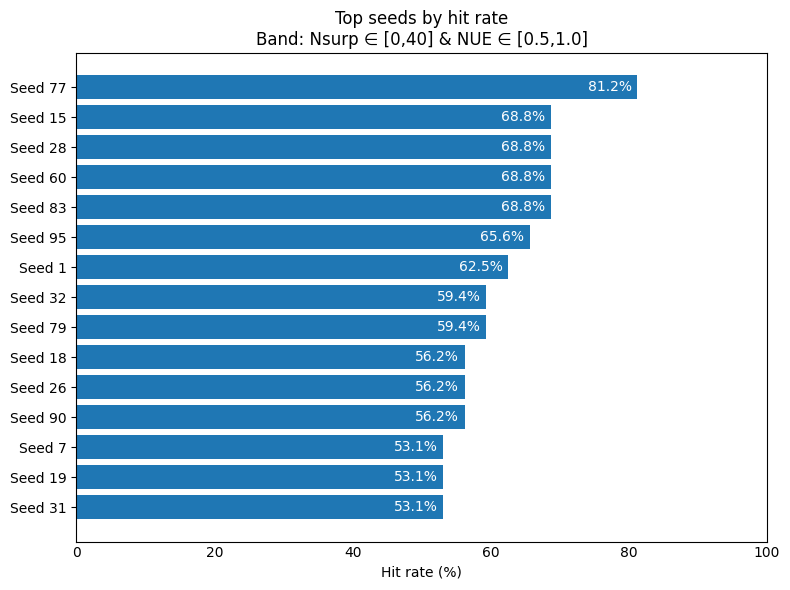

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path

# PDF-friendly fonts (no Type 3)
mpl.rcParams.update({
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "text.usetex": False,   # important: keeps Matplotlib text handling
    "font.family": "serif",
})

def wilson_ci(k, n, z=1.96):
    if n == 0:
        return (np.nan, np.nan)
    phat = k / n
    denom = 1 + z*z/n
    center = (phat + z*z/(2*n)) / denom
    margin = z*np.sqrt(phat*(1-phat)/n + z*z/(4*n*n)) / denom
    return center - margin, center + margin

# --- data prep ---
tmp = seed_summary.copy()
tmp["phat"] = tmp["hits"] / tmp["total_episodes"]

cis = tmp.apply(lambda r: wilson_ci(r["hits"], r["total_episodes"]), axis=1)
tmp["ci_lo"] = [c[0] for c in cis]
tmp["ci_hi"] = [c[1] for c in cis]

topN = tmp.sort_values(["phat", "hits", "total_episodes"],
                       ascending=[False, False, False]).head(15)
if len(topN) == 0:
    raise ValueError("No rows in topN; nothing to plot.")

y = np.arange(len(topN))[::-1]
values = (topN["phat"] * 100.0).to_numpy()

# --- plotting (bars only) ---
plt.close("all")
plt.style.use("default")

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.barh(y, values, edgecolor="none", linewidth=0)

ax.grid(False)
ax.tick_params(axis="x", length=0)
ax.set_yticks(y)
ax.set_yticklabels([f"Seed {int(s)}" for s in topN["seed"]])

ax.set_xlabel("Hit rate (%)")   # <-- no escaping needed
ax.set_xlim(0, 100)

# Uses your configured bands (NSURP_RANGE, NUE_RANGE must exist)
ax.set_title(
    f"Top seeds by hit rate\n"
    f"Band: Nsurp ∈ [{NSURP_RANGE[0]:.0f},{NSURP_RANGE[1]:.0f}] "
    f"& NUE ∈ [{NUE_RANGE[0]:.1f},{NUE_RANGE[1]:.1f}]"
)

# --- labels INSIDE bars (fallback outside if bar is short) ---
threshold = 12.0  # percent; move label outside if bar shorter than this
for rect, v in zip(bars, values):
    y_mid = rect.get_y() + rect.get_height() / 2
    if v >= threshold:
        ax.text(v - 0.8, y_mid, f"{v:.1f}%", va="center", ha="right", color="white")
    else:
        ax.text(v + 0.8, y_mid, f"{v:.1f}%", va="center", ha="left", color="black")

fig.tight_layout()

# --- save (LaTeX-friendly tight bounding box) ---
outdir = Path("figures")
outdir.mkdir(exist_ok=True)
outfile = outdir / "top_seeds_hit_rate_nue.pdf"
fig.savefig(outfile, bbox_inches="tight", pad_inches=0.02)
print(f"Saved: {outfile.resolve()}")

plt.show()
plt.close(fig)


Saved: C:\Users\Simon\PycharmProjects\Masterthesis_Upload\figures\all_seeds_hit_rate.pdf


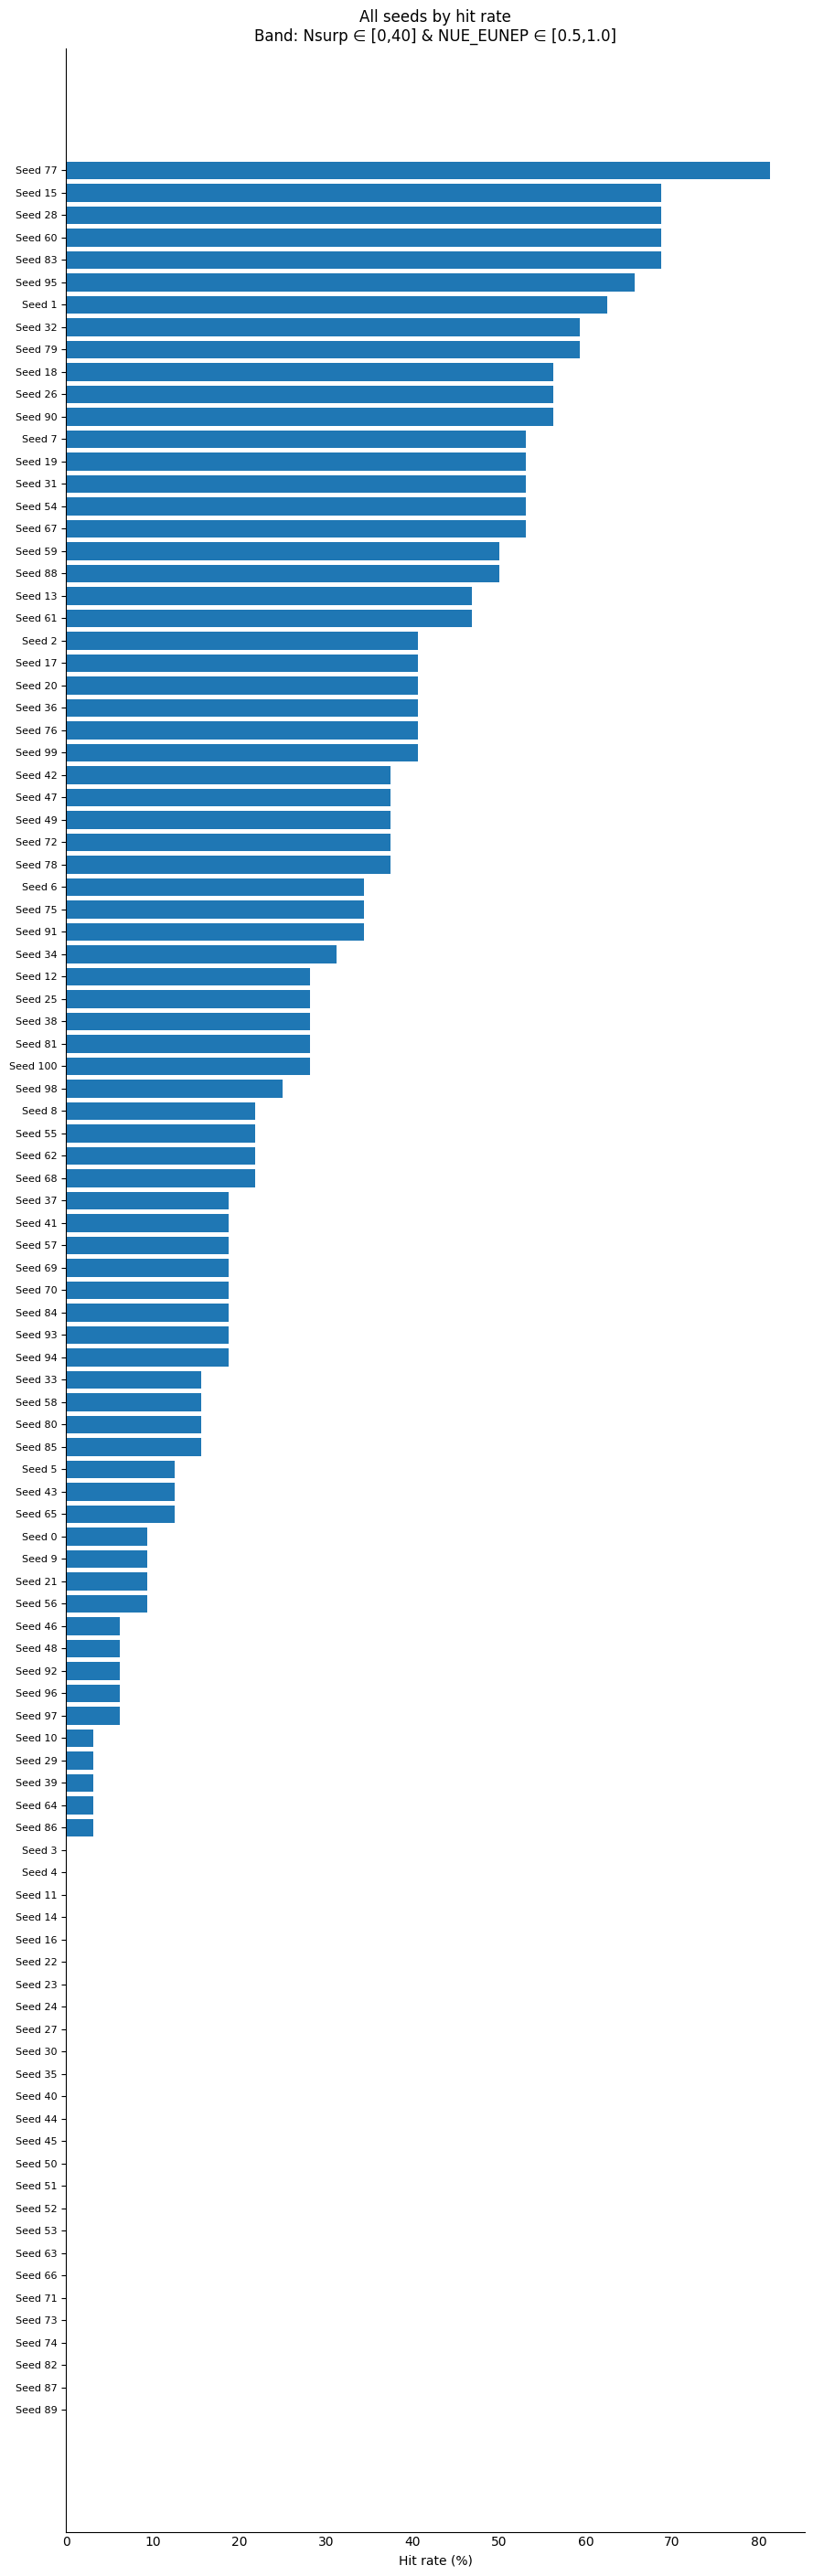

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path

# PDF-friendly fonts (no Type 3)
mpl.rcParams.update({
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "text.usetex": False,
    "font.family": "serif",
})

# --- compute hit rates & CIs (reusing your function, though CI not plotted) ---
def wilson_ci(k, n, z=1.96):
    if n == 0:
        return (np.nan, np.nan)
    phat = k / n
    denom = 1 + z*z/n
    center = (phat + z*z/(2*n)) / denom
    margin = z*np.sqrt(phat*(1-phat)/n + z*z/(4*n*n)) / denom
    return center - margin, center + margin

tmp = seed_summary.copy()
tmp["phat"] = tmp["hits"] / tmp["total_episodes"]
cis = tmp.apply(lambda r: wilson_ci(r["hits"], r["total_episodes"]), axis=1)
tmp["ci_lo"] = [c[0] for c in cis]
tmp["ci_hi"] = [c[1] for c in cis]

# --- ALL seeds, sorted by hit rate descending ---
all_seeds = tmp.sort_values(["phat","hits","total_episodes"],
                            ascending=[False,False,False]).reset_index(drop=True)

n = len(all_seeds)
if n == 0:
    raise ValueError("No seeds found; nothing to plot.")

# Auto figure height so labels are readable (tweak bar_height if needed)
bar_height = 0.28  # inches per bar; raise if labels feel cramped
fig_h = max(6, bar_height * n)

y = np.arange(n)[::-1]
values = (all_seeds["phat"] * 100.0).to_numpy()

# --- plotting (bars only) ---
plt.close('all')
plt.style.use('default')

fig, ax = plt.subplots(figsize=(9, fig_h))
ax.barh(y, values, edgecolor="none", linewidth=0)

# No error bars and no in-bar percentages on purpose
ax.grid(False)
ax.tick_params(axis='x', length=0)
ax.set_yticks(y)
ax.set_yticklabels([f"Seed {int(s)}" for s in all_seeds["seed"]], fontsize=8)
ax.set_xlabel("Hit rate (%)")
ax.set_title("All seeds by hit rate\nBand: Nsurp ∈ [0,40] & NUE_EUNEP ∈ [0.5,1.0]")

# Optional: show a thin x-axis line and hide top/right spines
for spine in ["top","right"]:
    ax.spines[spine].set_visible(False)

fig.tight_layout()

# --- save BEFORE show ---
outdir = Path("figures"); outdir.mkdir(exist_ok=True)
outfile = outdir / "all_seeds_hit_rate.pdf"
fig.savefig(outfile, format="pdf", bbox_inches="tight")
print(f"Saved: {outfile.resolve()}")

plt.show()
plt.close(fig)


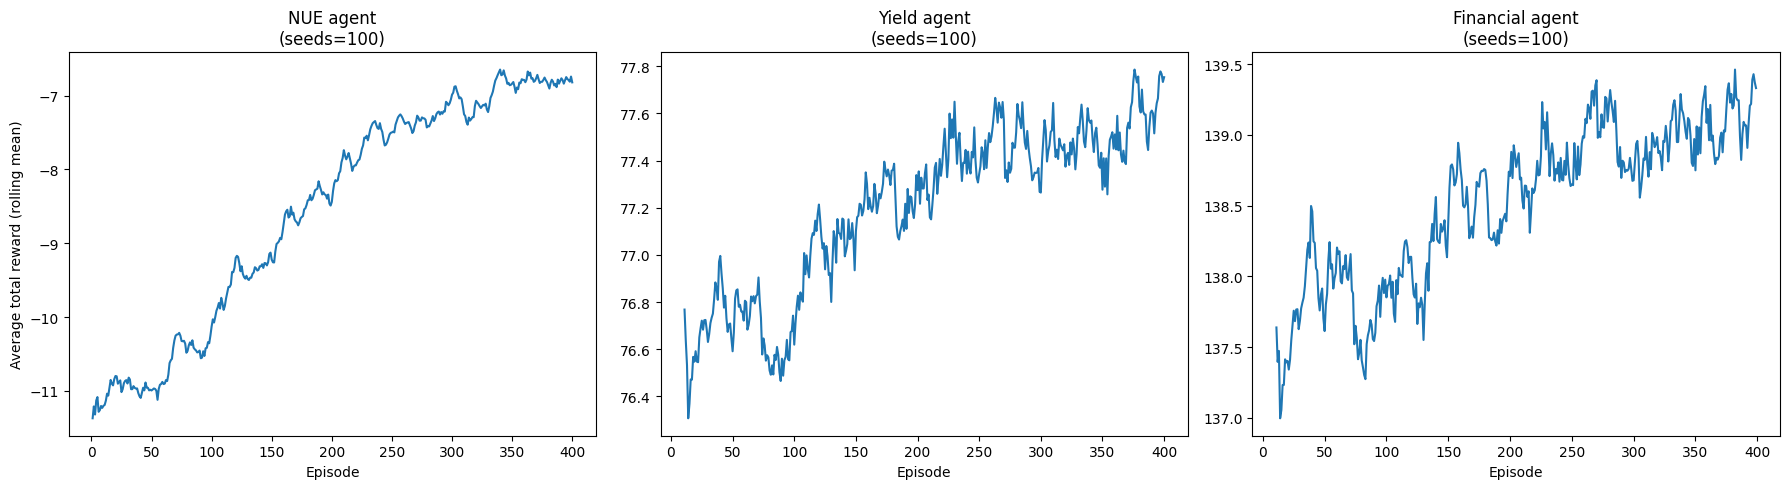

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
# --------------------------------------------------------------------
# Paths
# --------------------------------------------------------------------


# 1. Get the current working directory
project_root = Path.cwd()

# 2. Define the paths relative to the project root
PATH_NUE_COMBINED   = project_root / "results/combined_csvs/combined_episode_logs_nue.csv"
PATH_YIELD_COMBINED = project_root / "results/combined_csvs/combined_episode_logs_yield.csv"
PATH_FIN_COMBINED   = project_root / "results/combined_csvs/combined_episode_logs_financial.csv"

# Output PDF path (adjust folder/name if you like)
OUT_PDF = "training_rewards_rolling_mean.pdf"

window = 10  # rolling window

# --------------------------------------------------------------------
# NUE agent (all episodes)
# --------------------------------------------------------------------
df_nue = pd.read_csv(PATH_NUE_COMBINED)
nue_seeds = df_nue["seed"].nunique()

episode_mean_nue = (
    df_nue.groupby("episode")["total_reward"]
          .mean()
          .sort_index()
)
rolling_nue = episode_mean_nue.rolling(window=window, min_periods=1).mean()

# --------------------------------------------------------------------
# YIELD agent (episodes > 10)
# --------------------------------------------------------------------
df_yield = pd.read_csv(PATH_YIELD_COMBINED)
df_yield = df_yield[df_yield["episode"] > 10]
yield_seeds = df_yield["seed"].nunique()

episode_mean_yield = (
    df_yield.groupby("episode")["total_reward"]
            .mean()
            .sort_index()
)
rolling_yield = episode_mean_yield.rolling(window=window, min_periods=1).mean()

# --------------------------------------------------------------------
# FINANCIAL agent (10 < episode < 400)
# --------------------------------------------------------------------
df_fin = pd.read_csv(PATH_FIN_COMBINED)
df_fin = df_fin[(df_fin["episode"] > 10) & (df_fin["episode"] < 400)]
fin_seeds = df_fin["seed"].nunique()

episode_mean_fin = (
    df_fin.groupby("episode")["total_reward"]
          .mean()
          .sort_index()
)
rolling_fin = episode_mean_fin.rolling(window=window, min_periods=1).mean()

# --------------------------------------------------------------------
# Plot: 3 subplots next to each other, each with its own y-scale
# --------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # no sharey

# NUE
axes[0].plot(rolling_nue.index, rolling_nue.values)
axes[0].set_title(f"NUE agent\n(seeds=100)")
axes[0].set_xlabel("Episode")
axes[0].set_ylabel("Average total reward (rolling mean)")

# YIELD
axes[1].plot(rolling_yield.index, rolling_yield.values)
axes[1].set_title(f"Yield agent\n(seeds=100)")
axes[1].set_xlabel("Episode")

# FINANCIAL
axes[2].plot(rolling_fin.index, rolling_fin.values)
axes[2].set_title(f"Financial agent\n(seeds=100)")
axes[2].set_xlabel("Episode")

plt.tight_layout()

# 🔹 Save as vector PDF for LaTeX
fig.savefig(OUT_PDF, format="pdf", bbox_inches="tight")

# Optional: still show it interactively
plt.show()


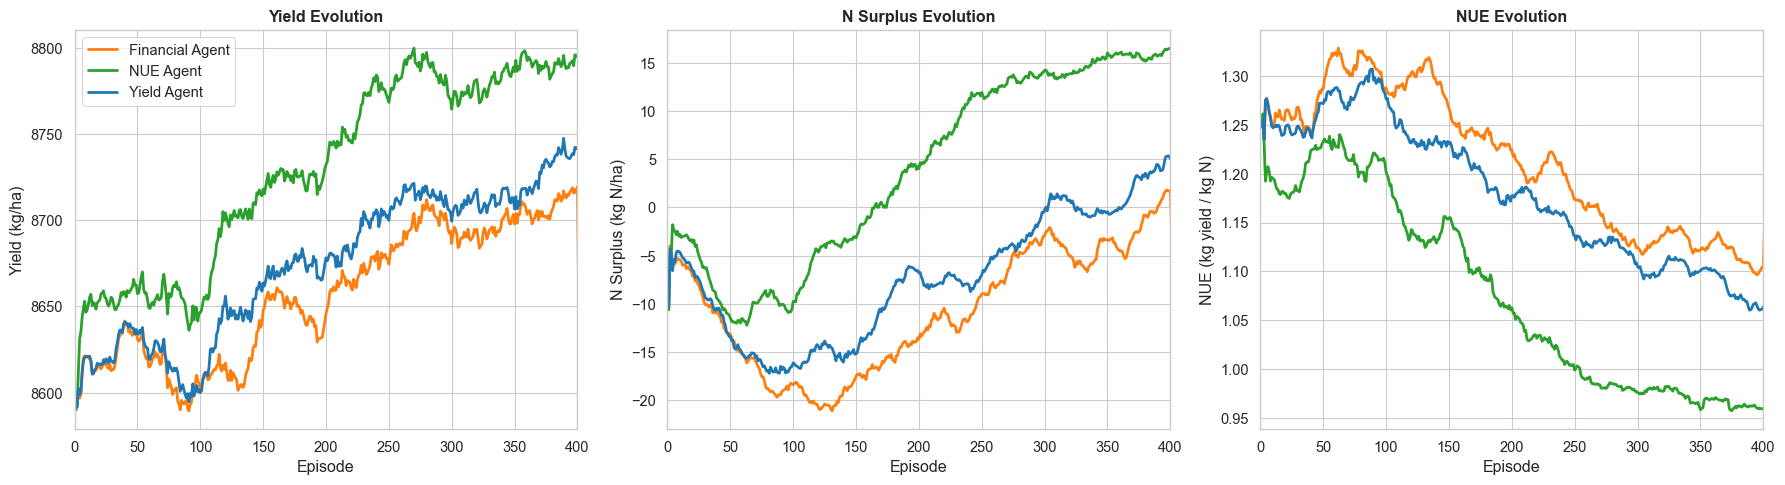

In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

project_root = Path.cwd()

# 2. Read the CSVs using the dynamic path
# We use the / operator to join the root path with the relative path
df_yield = pd.read_csv(project_root / "results/combined_csvs/combined_episode_logs_yield.csv")
df_financial = pd.read_csv(project_root / "results/combined_csvs/combined_episode_logs_financial.csv")
df_nue = pd.read_csv(project_root / "results/combined_csvs/combined_episode_logs_nue.csv")

# 2. Label the data
df_yield['Agent'] = 'Yield Agent'
df_financial['Agent'] = 'Financial Agent'
df_nue['Agent'] = 'NUE Agent'

# 3. Combine into one DataFrame
combined_df = pd.concat([df_yield, df_financial, df_nue], ignore_index=True)

# 4. Smoothing Function
rolling_window = 20
metrics = ['yield_kg_ha', 'nsurp', 'nue_fert']

df_smoothed = combined_df.copy()
# Sort to ensure rolling average is calculated correctly over episodes
df_smoothed = df_smoothed.sort_values(by=['Agent', 'seed', 'episode'])

# Apply rolling average
for metric in metrics:
    df_smoothed[metric] = df_smoothed.groupby(['Agent', 'seed'])[metric].transform(
        lambda x: x.rolling(window=rolling_window, min_periods=1).mean()
    )

# 5. Plotting
# 'context="paper"' is optimized for documents/papers
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

custom_palette = {
    'Yield Agent': '#1f77b4',     # Blue
    'Financial Agent': '#ff7f0e', # Orange
    'NUE Agent': '#2ca02c'        # Green
}

# --- Plot 1: Yield ---
sns.lineplot(
    data=df_smoothed, x='episode', y='yield_kg_ha', hue='Agent',
    ax=axes[0], palette=custom_palette, errorbar=None, linewidth=2
)
axes[0].set_title('Yield Evolution', fontweight='bold')
axes[0].set_ylabel('Yield (kg/ha)')
axes[0].set_xlabel('Episode')
axes[0].set_xlim(0, 400)
axes[0].legend(title=None)

# --- Plot 2: N Surplus ---
sns.lineplot(
    data=df_smoothed, x='episode', y='nsurp', hue='Agent',
    ax=axes[1], palette=custom_palette, errorbar=None, linewidth=2
)
axes[1].set_title('N Surplus Evolution', fontweight='bold')
axes[1].set_ylabel('N Surplus (kg N/ha)')
axes[1].set_xlabel('Episode')
axes[1].set_xlim(0, 400)
if axes[1].get_legend(): axes[1].legend().remove()

# --- Plot 3: NUE ---
sns.lineplot(
    data=df_smoothed, x='episode', y='nue_fert', hue='Agent',
    ax=axes[2], palette=custom_palette, errorbar=None, linewidth=2
)
axes[2].set_title('NUE Evolution', fontweight='bold')
axes[2].set_ylabel('NUE (kg yield / kg N)')
axes[2].set_xlabel('Episode')
axes[2].set_xlim(0, 400)
if axes[2].get_legend(): axes[2].legend().remove()

plt.tight_layout()

# Save as PDF for LaTeX
# bbox_inches='tight' ensures no labels are cut off
plt.savefig('evolution_graphs.pdf', format='pdf', bbox_inches='tight')

plt.show()

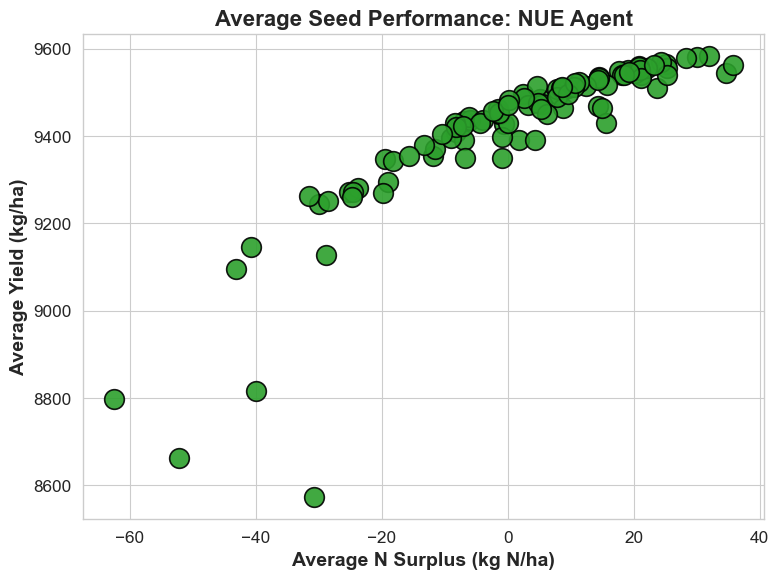

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

project_root = Path.cwd()

# Note: The file names now include 'testing_' as per your request
df_yield = pd.read_csv(project_root / "results/combined_csvs/testing_combined_episode_logs_yield.csv")
df_financial = pd.read_csv(project_root / "results/combined_csvs/testing_combined_episode_logs_financial.csv")
df_nue = pd.read_csv(project_root / "results/combined_csvs/testing_combined_episode_logs_nue.csv")

# 2. Label the agents
df_yield['Agent'] = 'Yield Agent'
df_financial['Agent'] = 'Financial Agent'
df_nue['Agent'] = 'NUE Agent'

# 3. Combine the data
combined_df = pd.concat([df_yield, df_financial, df_nue], ignore_index=True)

# 4. Aggregation: Average over the 32 runs per seed
df_agg = combined_df.groupby(['Agent', 'seed'])[['Yield', 'Nsurp']].mean().reset_index()

# 5. Filter for a SINGLE Agent
# You can change this to any agent you want to plot
target_agent = 'NUE Agent'
df_single_agent = df_agg[df_agg['Agent'] == target_agent]

# 6. Plotting
sns.set_theme(style="whitegrid", context="paper", font_scale=1.4)

plt.figure(figsize=(8, 6))

# Plot with Green Dots
sns.scatterplot(
    data=df_single_agent,
    x='Nsurp',
    y='Yield',
    marker='o',        # <--- Changed to 'o' for dots/circles
    color='#2ca02c',   # <--- Changed to green
    s=200,             # Increased size for better visibility of the dot
    edgecolor='black', # Adds a border to make it pop
    linewidth=1.2,
    alpha=0.9
)

# Labels
plt.title(f'Average Seed Performance: {target_agent}', fontsize=16, fontweight='bold')
plt.ylabel('Average Yield (kg/ha)', fontsize=14, fontweight='bold')
plt.xlabel('Average N Surplus (kg N/ha)', fontsize=14, fontweight='bold')

plt.tight_layout()

# 7. Save as PDF for LaTeX
filename = f'avg_seed_performance_{target_agent.replace(" ", "_")}_dots.pdf'
plt.savefig(filename, format='pdf', bbox_inches='tight')

plt.show()

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
# Load the three CSV files

RESULTS_DIR = Path.cwd() / "results/combined_csvs"

# 2. Read the CSVs using the dynamic path
yield_df     = pd.read_csv(RESULTS_DIR / "testing_combined_episode_logs_yield.csv")
financial_df = pd.read_csv(RESULTS_DIR / "testing_combined_episode_logs_financial.csv")
nue_df       = pd.read_csv(RESULTS_DIR / "testing_combined_episode_logs_nue.csv")



# Create summary dataframe with mean ± std
def format_with_std(df, metric):
    """Format: mean ± std"""
    grouped = df.groupby('seed')[metric].mean()
    mean_val = grouped.mean()
    std_val = grouped.std()
    return f"{mean_val:.2f} ± {std_val:.2f}"

# Create formatted summary
summary_formatted = pd.DataFrame({
    'Yield (kg/ha)': [
        format_with_std(yield_df, 'Yield'),
        format_with_std(financial_df, 'Yield'),
        format_with_std(nue_df, 'Yield')
    ],
    'Nsurp (kg/ha)': [
        format_with_std(yield_df, 'Nsurp'),
        format_with_std(financial_df, 'Nsurp'),
        format_with_std(nue_df, 'Nsurp')
    ],
    'NUE_EUNEP': [
        format_with_std(yield_df, 'NUE_EUNEP'),
        format_with_std(financial_df, 'NUE_EUNEP'),
        format_with_std(nue_df, 'NUE_EUNEP')
    ]
}, index=['Yield Reward', 'Financial Reward', 'NUE Reward'])

print("\n" + "="*80)
print("SUMMARY - Overall Averages Across All Seeds (mean ± std)")
print("="*80)
print(summary_formatted)

# Also create numeric summary for plotting
summary = pd.DataFrame({
    'Yield (kg/ha)': [
        yield_df['Yield'].mean(),
        financial_df['Yield'].mean(),
        nue_df['Yield'].mean()
    ],
    'Nsurp (kg/ha)': [
        yield_df['Nsurp'].mean(),
        financial_df['Nsurp'].mean(),
        nue_df['Nsurp'].mean()
    ],
    'NUE_EUNEP': [
        yield_df['NUE_EUNEP'].mean(),
        financial_df['NUE_EUNEP'].mean(),
        nue_df['NUE_EUNEP'].mean()
    ]
}, index=['Yield Reward', 'Financial Reward', 'NUE Reward'])




SUMMARY - Overall Averages Across All Seeds (mean ± std)
                     Yield (kg/ha)   Nsurp (kg/ha)    NUE_EUNEP
Yield Reward      9230.12 ± 484.26  -13.23 ± 40.27  1.89 ± 5.07
Financial Reward  9302.66 ± 317.76   -6.86 ± 37.10  1.40 ± 2.51
NUE Reward        9420.07 ± 178.54    1.29 ± 19.58  1.09 ± 0.61


In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load the three CSV files


# 1. Define the base "results" folder
RESULTS_DIR = Path.cwd() / "results"

# 2. Load the files from their specific sub-folders
yield_df     = pd.read_csv(RESULTS_DIR / "eval_logs_yield/seed_77__eval_results_seed_77.csv")
financial_df = pd.read_csv(RESULTS_DIR / "eval_logs_financial/seed_8__eval_results_seed_8.csv")
nue_df       = pd.read_csv(RESULTS_DIR / "eval_results_seed_0to100_nue/eval_results_seed_49.csv")

# Load data from all three directories
print("\n" + "="*80)
print("Loading data from directories...")
print("="*80)

yield_data = yield_df
financial_data = financial_df
nue_data = nue_df

# Function to format mean (min-max)
def format_with_minmax(data, metric):
    """Format: mean (min-max)"""
    if data is None or metric not in data.columns:
        return "N/A"
    mean_val = data[metric].mean()
    min_val = data[metric].min()
    max_val = data[metric].max()
    return f"{mean_val:.2f} ({min_val:.2f}-{max_val:.2f})"

# Create formatted summary
summary_formatted = pd.DataFrame({
    'Yield (kg/ha)': [
        format_with_minmax(yield_data, 'Yield'),
        format_with_minmax(financial_data, 'Yield'),
        format_with_minmax(nue_data, 'Yield')
    ],
    'Nsurp (kg/ha)': [
        format_with_minmax(yield_data, 'Nsurp'),
        format_with_minmax(financial_data, 'Nsurp'),
        format_with_minmax(nue_data, 'Nsurp')
    ],
    'NUE_EUNEP': [
        format_with_minmax(yield_data, 'NUE_EUNEP'),
        format_with_minmax(financial_data, 'NUE_EUNEP'),
        format_with_minmax(nue_data, 'NUE_EUNEP')
    ]
}, index=['Yield Reward', 'Financial Reward', 'NUE Reward'])

print("\n" + "="*80)
print("SUMMARY - Overall Averages Across Best Seeds (mean (min-max))")
print("="*80)
print(summary_formatted)

# Also create numeric summary for plotting
summary = pd.DataFrame({
    'Yield (kg/ha)': [
        yield_data['Yield'].mean() if yield_data is not None else np.nan,
        financial_data['Yield'].mean() if financial_data is not None else np.nan,
        nue_data['Yield'].mean() if nue_data is not None else np.nan
    ],
    'Nsurp (kg/ha)': [
        yield_data['Nsurp'].mean() if yield_data is not None else np.nan,
        financial_data['Nsurp'].mean() if financial_data is not None else np.nan,
        nue_data['Nsurp'].mean() if nue_data is not None else np.nan
    ],
    'NUE_EUNEP': [
        yield_data['NUE_EUNEP'].mean() if yield_data is not None else np.nan,
        financial_data['NUE_EUNEP'].mean() if financial_data is not None else np.nan,
        nue_data['NUE_EUNEP'].mean() if nue_data is not None else np.nan
    ]
}, index=['Yield Reward', 'Financial Reward', 'NUE Reward'])


Loading data from directories...

SUMMARY - Overall Averages Across Best Seeds (mean (min-max))
                               Yield (kg/ha)         Nsurp (kg/ha)  \
Yield Reward      9535.88 (8149.68-10474.30)  13.20 (-19.88-47.66)   
Financial Reward  9553.63 (8148.93-10471.05)    19.09 (0.42-47.67)   
NUE Reward        9550.89 (8139.38-10471.29)    20.39 (0.41-47.87)   

                         NUE_EUNEP  
Yield Reward      0.94 (0.78-1.11)  
Financial Reward  0.91 (0.78-1.00)  
NUE Reward        0.91 (0.78-1.00)  


In [60]:
import pandas as pd

# Define the columns you want to load
columns_to_load = ['total_reward', 'NUE_EUNEP', 'Nsurp', 'Napplied', 'Napps', 'Yield', 'year']

# Load the CSV file with only specific columns
from pathlib import Path
import pandas as pd

project_root = Path.cwd()

# Read the specific NUE seed file
df = pd.read_csv(project_root / "results/eval_results_seed_0to100_nue/eval_results_seed_49.csv", usecols=columns_to_load)


# Display the DataFrame
df

,total_reward,NUE_EUNEP,Nsurp,Napplied,Napps,Yield,year
0,-4.454362,0.835444,35.133114,210.0,4,8765.104480,1983
1,-4.428572,0.855109,30.934702,210.0,4,8971.420438,1984
2,-4.427613,0.855841,30.778353,210.0,4,8979.093027,1985
3,-4.859653,0.961966,8.120456,210.0,4,10092.507975,1986
4,-4.838822,0.933731,14.148810,210.0,4,9796.351271,1988
5,-4.834535,0.927918,15.389753,210.0,4,9735.303559,1989
6,-4.853425,0.953524,9.922707,210.0,4,10003.958562,1990
7,-4.815245,0.901769,20.972689,210.0,4,9460.953381,1991
8,-4.886284,0.998066,0.412875,210.0,4,10471.293523,1992
9,-4.884069,0.995065,1.053705,210.0,4,10439.812898,1993


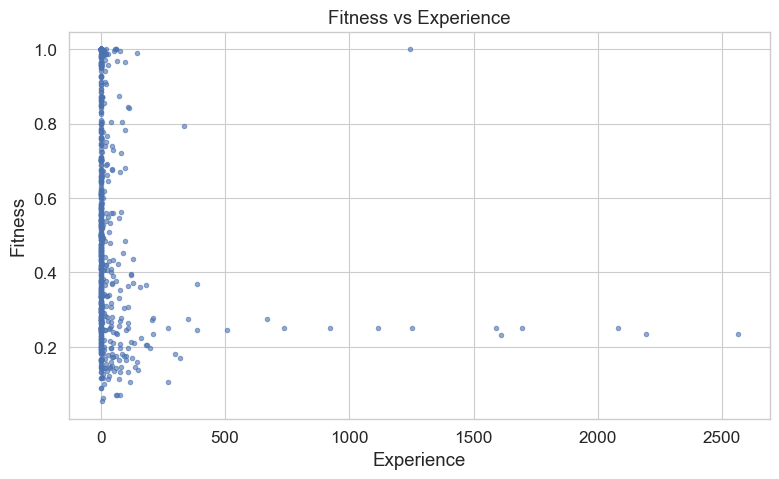

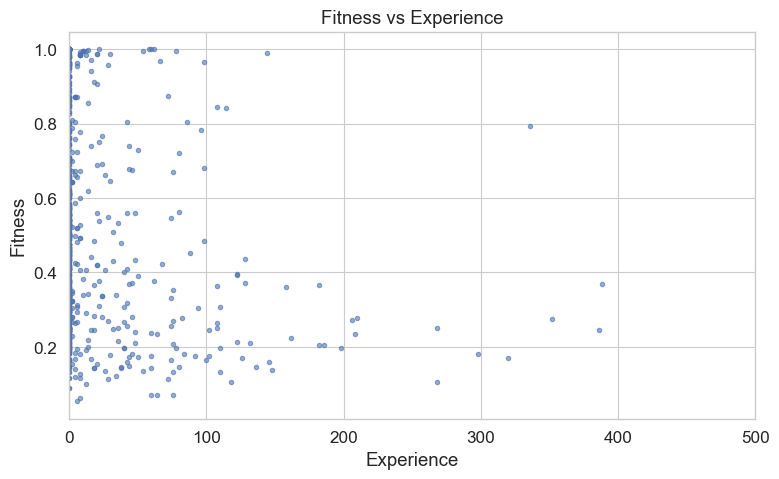

In [61]:

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === CONFIG ===
from pathlib import Path

project_root = Path.cwd()

# Define the path relative to the project root
POP_PATH = project_root / "data/wofost81/output/population_min.csv"
LOG_X_EXPERIENCE = False  # set True if experience is very skewed

# === LOAD ===
df = pd.read_csv(POP_PATH)

def resolve_col(df, candidates, fallback_contains=None, required=True, friendly_name="column"):
    # exact
    for c in candidates:
        if c in df.columns:
            return c
    # case-insensitive
    lower_map = {c.lower(): c for c in df.columns}
    for c in candidates:
        if c.lower() in lower_map:
            return lower_map[c.lower()]
    # substring
    if fallback_contains:
        for c in df.columns:
            if fallback_contains.lower() in c.lower():
                return c
    if required:
        raise KeyError(f"Could not resolve {friendly_name}. Tried {candidates}. Available: {list(df.columns)}")
    return None

fitness_col = resolve_col(df, ["fit", "fitness", "avg_fitness", "classifier_fitness"], "fit", True, "fitness")
exp_col     = resolve_col(df, ["exp", "experience", "experience_count"], "exp", True, "experience")
num_col     = resolve_col(df, ["num", "numerosity", "n"], "num", False, "numerosity")

# Cast + clean
df[fitness_col] = pd.to_numeric(df[fitness_col], errors="coerce")
df[exp_col]     = pd.to_numeric(df[exp_col], errors="coerce")
if num_col is not None:
    df[num_col] = pd.to_numeric(df[num_col], errors="coerce")

df = df.dropna(subset=[fitness_col, exp_col]).copy()
if df.empty:
    raise ValueError("No rows left after dropping NaNs in fitness/experience.")

# Numerosity handling
if num_col is None:
    df["_num_"] = 1.0
    num_col = "_num_"
else:
    df[num_col] = df[num_col].fillna(1.0)




# --- 3) Fitness vs Experience scatter ---
plt.figure(figsize=(8,5))
plt.scatter(df[exp_col].values, df[fitness_col].values, s=10, alpha=0.6)
plt.xlabel("Experience")
plt.ylabel("Fitness")
plt.title("Fitness vs Experience")
if LOG_X_EXPERIENCE:
    plt.xscale("log")
plt.tight_layout()
plt.show()

# --- 3) Fitness vs Experience scatter ---
plt.figure(figsize=(8,5))
plt.scatter(df[exp_col].values, df[fitness_col].values, s=10, alpha=0.6)
plt.xlabel("Experience")
plt.ylabel("Fitness")
plt.title("Fitness vs Experience")
if LOG_X_EXPERIENCE:
    plt.xscale("log")
plt.xlim(0, 500)  # <--- Limit x-axis to 500
plt.tight_layout()
plt.show()


Resolved columns:
  fitness: fit
  experience: exp
  numerosity: num

Fitness summary:
count    800.000000
mean       0.530347
std        0.286202
min        0.053642
10%        0.195567
25%        0.277545
50%        0.478682
75%        0.763438
90%        0.999408
95%        1.000000
99%        1.000000
max        1.000000
Name: fit, dtype: float64

Experience summary:
count     800.000000
mean       39.145000
std       196.377071
min         0.000000
10%         0.000000
25%         0.000000
50%         0.000000
75%         8.000000
90%        68.400000
95%       122.000000
99%      1117.280000
max      2564.000000
Name: exp, dtype: float64


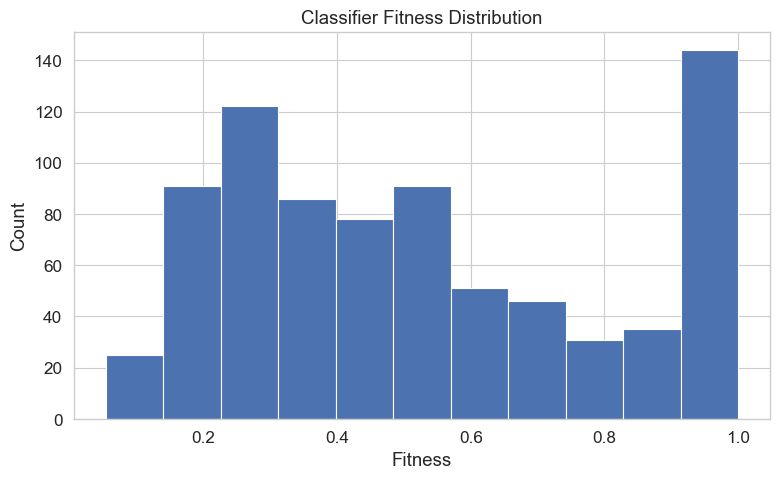

In [62]:
# Display-only: fitness histograms + fitness vs. experience (no saving)
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


project_root = Path.cwd()

# Define the path relative to the project root
POP_PATH = project_root / "data/wofost81/output/population_min.csv"
LOG_X_EXPERIENCE = False  # set True if experience is very skewed

# === LOAD ===
df = pd.read_csv(POP_PATH)

def resolve_col(df, candidates, fallback_contains=None, required=True, friendly_name="column"):
    # exact
    for c in candidates:
        if c in df.columns:
            return c
    # case-insensitive
    lower_map = {c.lower(): c for c in df.columns}
    for c in candidates:
        if c.lower() in lower_map:
            return lower_map[c.lower()]
    # substring
    if fallback_contains:
        for c in df.columns:
            if fallback_contains.lower() in c.lower():
                return c
    if required:
        raise KeyError(f"Could not resolve {friendly_name}. Tried {candidates}. Available: {list(df.columns)}")
    return None

fitness_col = resolve_col(df, ["fit", "fitness", "avg_fitness", "classifier_fitness"], "fit", True, "fitness")
exp_col     = resolve_col(df, ["exp", "experience", "experience_count"], "exp", True, "experience")
num_col     = resolve_col(df, ["num", "numerosity", "n"], "num", False, "numerosity")

# Cast + clean
df[fitness_col] = pd.to_numeric(df[fitness_col], errors="coerce")
df[exp_col]     = pd.to_numeric(df[exp_col], errors="coerce")
if num_col is not None:
    df[num_col] = pd.to_numeric(df[num_col], errors="coerce")

df = df.dropna(subset=[fitness_col, exp_col]).copy()
if df.empty:
    raise ValueError("No rows left after dropping NaNs in fitness/experience.")

# Numerosity handling
if num_col is None:
    df["_num_"] = 1.0
    num_col = "_num_"
else:
    df[num_col] = df[num_col].fillna(1.0)

print("Resolved columns:")
print(f"  fitness: {fitness_col}")
print(f"  experience: {exp_col}")
print(f"  numerosity: {num_col if num_col != '_num_' else 'not provided (assumed=1)'}")

# Quick stats to console
print("\nFitness summary:")
print(df[fitness_col].describe(percentiles=[.1,.25,.5,.75,.9,.95,.99]))
print("\nExperience summary:")
print(df[exp_col].describe(percentiles=[.1,.25,.5,.75,.9,.95,.99]))

# --- 1) Fitness histogram ---
fitness_vals = df[fitness_col].values
bin_edges = np.histogram_bin_edges(fitness_vals, bins="auto")  # reuse for weighted

plt.figure(figsize=(8,5))
plt.hist(fitness_vals, bins=bin_edges)
plt.xlabel("Fitness")
plt.ylabel("Count")
plt.title("Classifier Fitness Distribution")
plt.tight_layout()
plt.show()

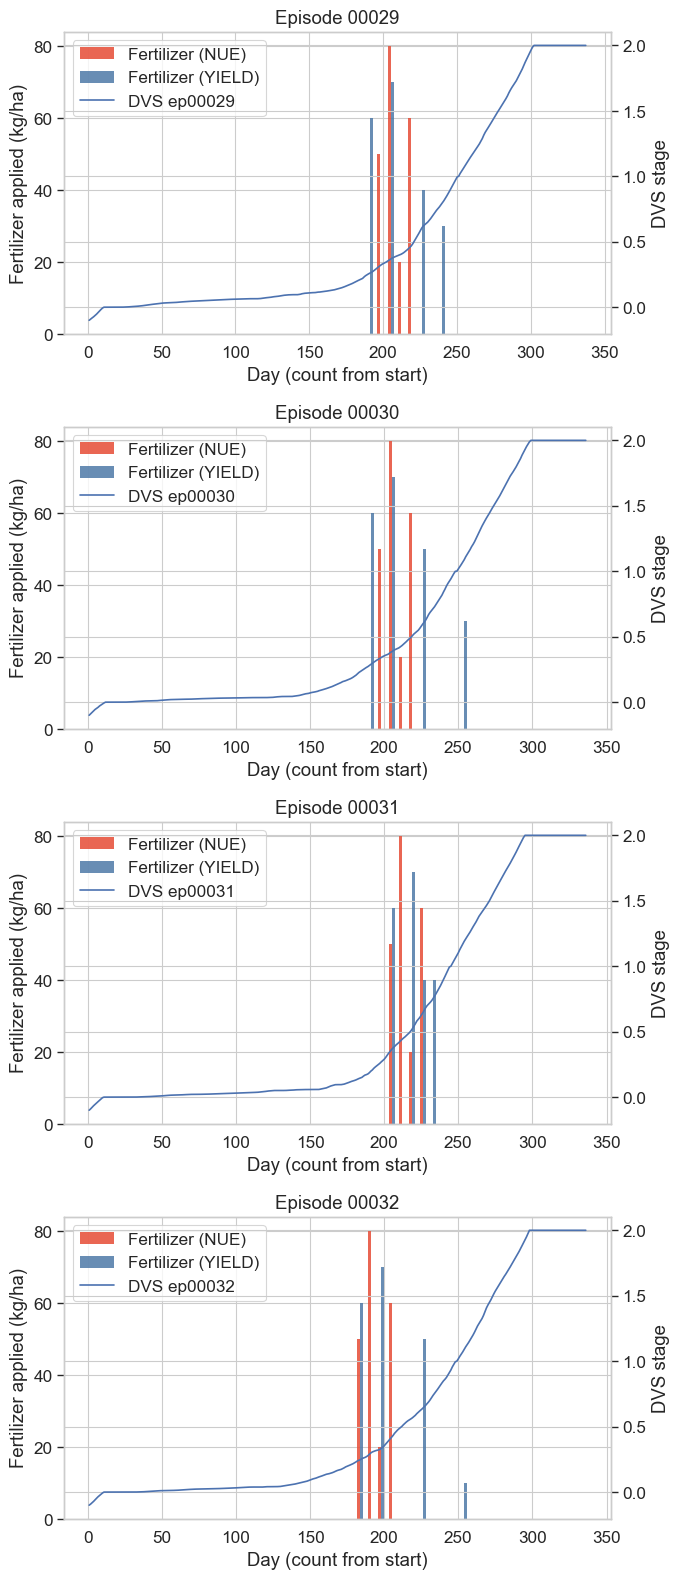

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from pathlib import Path

# 1. Define the base output folder
DATA_OUTPUT_DIR = Path.cwd() / "data/wofost81/output"

# 2. Create the list of paths relative to that base
base_dirs = [
    DATA_OUTPUT_DIR / "NUE",
    DATA_OUTPUT_DIR / "YIELD",
    # DATA_OUTPUT_DIR / "Financial",
]
prefix = "xcsr_ep"
suffix = "_pcse.xlsx"
episode_range = range(29, 33)   # 1..32 inclusive
KG_PER_UNIT = 10_000           # 0.008 -> 80 kg/ha

# Distinct bar styles per folder (auto-built from the folder names)
palette = ["#E64B35", "#4E79A7", "#59A14F", "#F28E2B"]  # colorblind-friendly
bar_styles = {}
for i, bdir in enumerate(base_dirs):
    bar_styles[bdir.name] = dict(
        color=palette[i % len(palette)],
        alpha=0.85,
        edgecolor="none",
        label=f"Fertilizer ({bdir.name})"
    )

# Which folder to prefer for drawing the DVS line (by folder name)
line_priority = [b.name for b in base_dirs]

# --- LOAD BOTH FOLDERS ---
# episodes_data[ep] -> { folder_name: df }
episodes_data = {}

for ep in episode_range:
    for base_dir in base_dirs:
        file_path = base_dir / f"{prefix}{ep:05d}{suffix}"
        if file_path.exists():
            df = pd.read_excel(file_path)
            df["day_index"] = range(1, len(df) + 1)
            df["episode"] = ep

            # --- compute fertilizer applications ---
            d_nh4 = df["RNH4AMTT"].diff().fillna(0)
            d_no3 = df["RNO3AMTT"].diff().fillna(0)
            # Only positive jumps are applications; convert to kg/ha
            df["fert_kg_ha"] = ((d_nh4 + d_no3).clip(lower=0)) * KG_PER_UNIT
            df["is_fert"] = df["fert_kg_ha"] > 0

            episodes_data.setdefault(ep, {})[base_dir.name] = df
        else:
            print(f"⚠️ File not found: {file_path}")

if not episodes_data:
    raise SystemExit("No input files found in either folder for the specified episodes.")

# --- PLOT ---
n = len(episodes_data)
fig, axes = plt.subplots(n, 1, figsize=(7, 4*n), sharex=False)
if n == 1:
    axes = [axes]

for ax, ep in zip(axes, sorted(episodes_data.keys())):
    data_by_folder = episodes_data[ep]

    # Bars (fertilizer) on LEFT axis
    sources = sorted(data_by_folder.keys())        # stable order
    k = max(1, len(sources))
    #total_width = 2
    bar_width = 2
    # offsets so bars from different folders at same day don't overlap
    offsets = {src: (i - (k - 1) / 2) * bar_width for i, src in enumerate(sources)}

    for src in sources:
        df_src = data_by_folder[src]
        apps = df_src[df_src["is_fert"]]
        if not apps.empty:
            ax.bar(
                apps["day_index"] + offsets[src],
                apps["fert_kg_ha"],
                width=bar_width,
                **bar_styles[src]
            )

    ax.set_ylabel("Fertilizer applied (kg/ha)")
    ax.set_xlabel("Day (count from start)")
    ax.set_ylim(bottom=0)

    # DVS on RIGHT axis
    ax2 = ax.twinx()
    ref_df = None
    for fname in line_priority:
        if fname in data_by_folder:
            ref_df = data_by_folder[fname]
            break
    if ref_df is None:
        ref_df = next(iter(data_by_folder.values()))

    ax2.plot(ref_df["day_index"], ref_df["DVS"], label=f"DVS ep{ep:05d}")
    ax2.set_ylabel("DVS stage")

    ax.set_title(f"Episode {ep:05d}")
    ax.grid(True, axis="both")

    # One combined legend
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax.legend(h1 + h2, l1 + l2, loc="upper left")

plt.tight_layout()
plt.show()
